<a href="https://colab.research.google.com/github/fatemehoseinzade/3Shapes/blob/develope/3Shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
# Connection With Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unrar x '/content/drive/MyDrive/ML/Dataset(shapes).rar'

In [6]:
file_path = '/content/drive/MyDrive/ML/images_and_labels_1.csv'

df = pd.read_csv(file_path)
print(f'data frame shape {df.shape}')

df.head(10)


data frame shape (1001, 8)


,image_path,labels,Circle_amount,Tri_amount,Rec_amount,Circle_ex,Tri_ex,Rec_ex
0,/content/combination_images/combination-0.png,", rectangle",0.0,0.0,3.0,0.0,0.0,1.0
1,/content/combination_images/combination-1.png,", rectangle",0.0,0.0,3.0,0.0,0.0,1.0
2,/content/combination_images/combination-10.png,"triangle, circle, rectangle",1.0,1.0,1.0,1.0,1.0,1.0
3,/content/combination_images/combination-100.png,"triangle, circle",2.0,1.0,0.0,1.0,1.0,0.0
4,/content/combination_images/combination-101.png,"triangle, rectangle",0.0,1.0,2.0,0.0,1.0,1.0
5,/content/combination_images/combination-102.png,"triangle, rectangle",0.0,1.0,2.0,0.0,1.0,1.0
6,/content/combination_images/combination-103.png,"triangle, rectangle",0.0,1.0,2.0,0.0,1.0,1.0
7,/content/combination_images/combination-104.png,", circle",1.0,0.0,0.0,1.0,0.0,0.0
8,/content/combination_images/combination-105.png,"triangle, rectangle",0.0,1.0,1.0,0.0,1.0,1.0
9,/content/combination_images/combination-106.png,", rectangle",0.0,0.0,3.0,0.0,0.0,1.0


In [8]:
labels = []

for idx , row in df.iterrows():
  labels.append(list(row.iloc[2:5]))

print(labels[:10])

labels = np.array(labels)
labels.shape

[[0.0, 0.0, 3.0], [0.0, 0.0, 3.0], [1.0, 1.0, 1.0], [2.0, 1.0, 0.0], [0.0, 1.0, 2.0], [0.0, 1.0, 2.0], [0.0, 1.0, 2.0], [1.0, 0.0, 0.0], [0.0, 1.0, 1.0], [0.0, 0.0, 3.0]]


(1001, 3)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=710x710 at 0x7C5278E682E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=692x692 at 0x7C527910BEB0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=612x612 at 0x7C5278E69570>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=664x664 at 0x7C5278E698A0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x700 at 0x7C5278E69BD0>


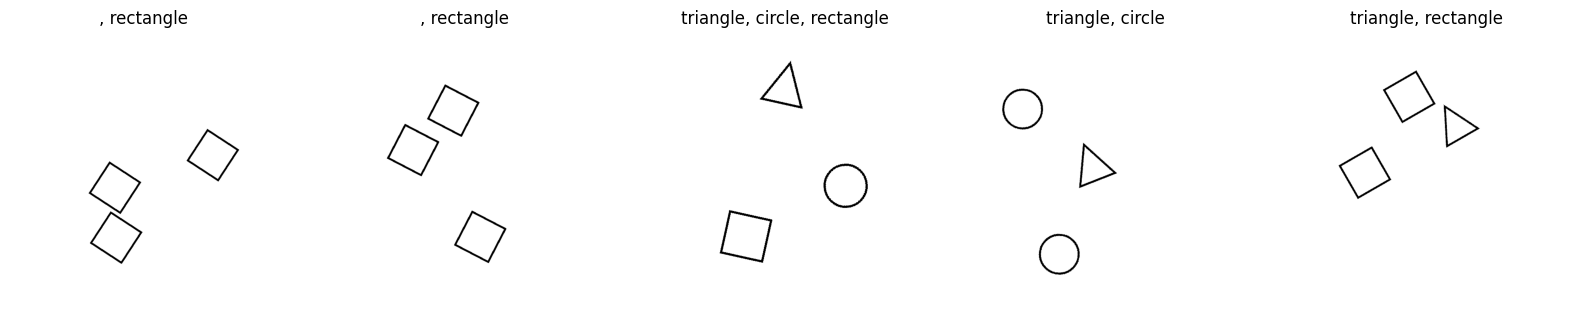

In [10]:
def show_images(df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        row = df.iloc[i]
        image = Image.open(row['image_path'])
        print(image)
        label = row['labels']
        axes[i].imshow(np.squeeze(image),cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

show_images(df, num_images=5)

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [13]:
from sklearn import preprocessing

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe =  dataframe[dataframe['image_path'].apply(lambda x: isinstance(x, str))]
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path)

        # Extracting labels, assuming they are in the last three columns
        label = list(self.dataframe.iloc[idx, 2:5])
        label = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        return image, label


In [14]:
# categories our data
BATCH_SIZE = 32

train_df , test_df = train_test_split(df, test_size = 0.2 ,shuffle=True)

print(f'Train_df shape {train_df.shape} , Test_df shape {test_df.shape}')

train_dataset = ImageDataset(train_df , transform = transform)
test_dataset = ImageDataset(test_df , transform = transform)
# predict_dataset = ImageDataset(predict_df , transform = transform)


train_data_loader = DataLoader(train_dataset , batch_size = BATCH_SIZE , shuffle= True)
test_data_loader = DataLoader(test_dataset , batch_size = BATCH_SIZE , shuffle = False)

print(f"Length of train dataloader: {len(train_data_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_data_loader)} batches of {BATCH_SIZE}")


image, label = next(iter(train_data_loader))

label.shape , image.shape

Train_df shape (800, 8) , Test_df shape (201, 8)
Length of train dataloader: 25 batches of 32
Length of test dataloader: 7 batches of 32


(torch.Size([32, 3]), torch.Size([32, 1, 64, 64]))

In [15]:
from torch import nn
class ShapeCounterCNN(nn.Module):
    def __init__(self):
        super(ShapeCounterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.fc1 = nn.Linear(30*30*10 , 3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x =self.pool(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1) # flatten the tensor
        x = self.fc1(x)
        x = torch.clamp(x, 0, 3)
        return x

In [16]:
my_model =ShapeCounterCNN()

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.05, momentum=0.9)


In [19]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc


In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        model.train()

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval() # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs= 6
for epoch in tqdm(range(epochs)) :
  print(f"Epoch: {epoch}\n---------")
  train_step( model = my_model, data_loader = train_data_loader, loss_fn = loss_fn, optimizer = optimizer, accuracy_fn = accuracy_fn)
  test_step( model = my_model, data_loader = test_data_loader, loss_fn = loss_fn, accuracy_fn= accuracy_fn)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 3.37347 | Train accuracy: 95.01%
Test loss: 3.42224 | Test accuracy: 101.54%

Epoch: 1
---------
Train loss: 3.37191 | Train accuracy: 98.24%
Test loss: 3.42224 | Test accuracy: 101.54%

Epoch: 2
---------
Train loss: 3.37135 | Train accuracy: 98.21%
Test loss: 3.42224 | Test accuracy: 101.54%

Epoch: 3
---------
Train loss: 3.37155 | Train accuracy: 98.25%
Test loss: 3.42224 | Test accuracy: 101.54%

Epoch: 4
---------
Train loss: 3.37110 | Train accuracy: 98.24%
Test loss: 3.42224 | Test accuracy: 101.54%

Epoch: 5
---------
Train loss: 3.37167 | Train accuracy: 98.26%
Test loss: 3.42224 | Test accuracy: 101.54%



In [22]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [23]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({test_labels[0]})")

Test sample image shape: torch.Size([1, 64, 64])
Test sample label: tensor([0., 2., 1.]) (tensor([0., 2., 1.]))


In [24]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=my_model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[0.0243, 0.4879, 0.4879],
        [0.0243, 0.4879, 0.4879]])

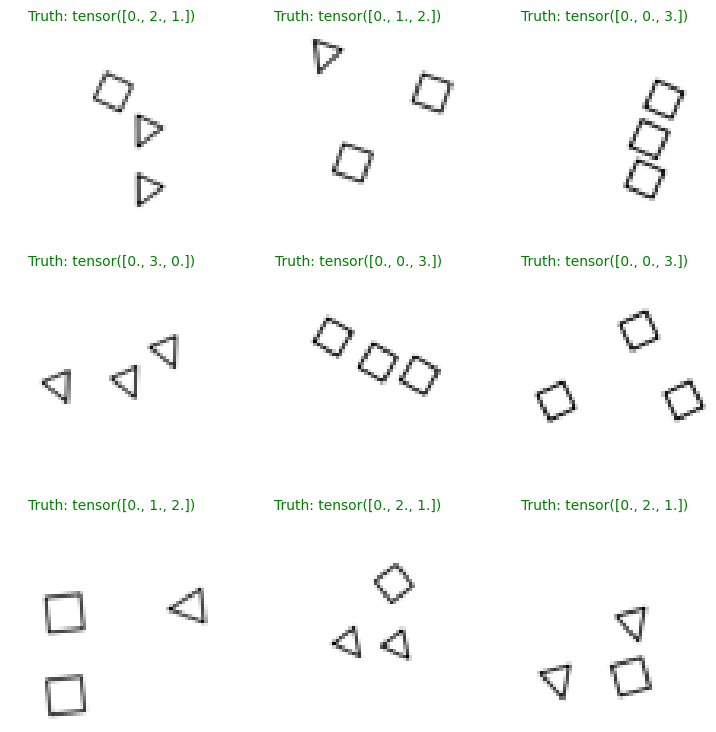

In [25]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  # pred_label = pred_classes[i]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = test_labels[i]

  # Create the title text of the plot
  title_text = f"Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  # if pred_label == truth_label:
  #     plt.title(title_text, fontsize=10, c="g") # green text if correct
  # else:
  plt.title(title_text, fontsize=10, c="g") # red text if wrong
  plt.axis(False);